In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

## Load the Dataset

To start, you will train the basic autoencoder using the Fashion MNIST dataset. Each image in this dataset is 28x28 pixels.

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

4431872/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


Build the model and fit

In [18]:
def build_fit(x_train=None, x_train_noisy=None, x_test=None, x_test_noisy= None, autoencoder=None, denoising=False):
  autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
  if denoising == True:
    autoencoder.fit(x_train_noisy, x_train,
                  epochs=10,
                  shuffle=True,
                  validation_data=(x_test_noisy, x_test))
  else:
      autoencoder.fit(x_train, x_train,
                  epochs=10,
                  shuffle=True,
                  validation_data=(x_test, x_test))


Display encoding and decoding images

In [22]:
def plot(original, decoded_imgs):
  n = 10
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(original[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

In [9]:
latent_dim = 64

## Basic Autoencoder

Define an autoencoder with two Dense layers: an encoder, which compresses the images into a 64 dimensional latent vector, and a decoder, that reconstructs the original image from the latent space.

In [3]:
class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    #784 is the dim of the image, 28*28pixels
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


In [8]:
autoencoder = Autoencoder(latent_dim)
build_fit(x_train=x_train, x_test=x_test, autoencoder=autoencoder)

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0236 - val_loss: 0.0132
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0116 - val_loss: 0.0107
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0100 - val_loss: 0.0097
Epoch 4/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0094 - val_loss: 0.0093
Epoch 5/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0091 - val_loss: 0.0092
Epoch 6/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 7/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0088 - val_loss: 0.0088
Epoch 9/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0087 - val_loss: 0.0088
Epoch 10/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.008

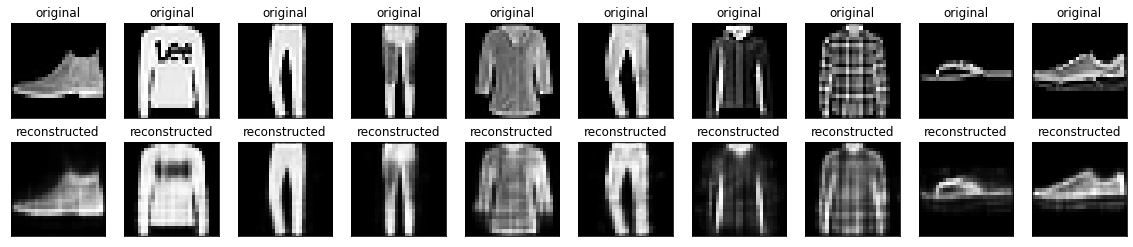

In [6]:

encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plot(decoded_imgs=decoded_imgs)

## Sparse Autoencoder

In [14]:
from keras import regularizers

class SparseAutoencoder(Model):
  # add regularizer to dense layer
  def __init__(self, latent_dim):
    super().__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activity_regularizer=regularizers.l1(10e-5),
                   activation='relu'),
    ])
    #784 is the dim of the image, 28*28pixels
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [15]:
autoencoder = SparseAutoencoder(latent_dim)
build_fit(x_train=x_train, x_test=x_test, autoencoder=autoencoder)

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0298 - val_loss: 0.0188
Epoch 2/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0170 - val_loss: 0.0158
Epoch 3/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0151 - val_loss: 0.0147
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0142 - val_loss: 0.0140
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0137 - val_loss: 0.0137
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0133 - val_loss: 0.0133
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0130 - val_loss: 0.0130
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0128 - val_loss: 0.0128
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0126 - val_loss: 0.0126
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.012

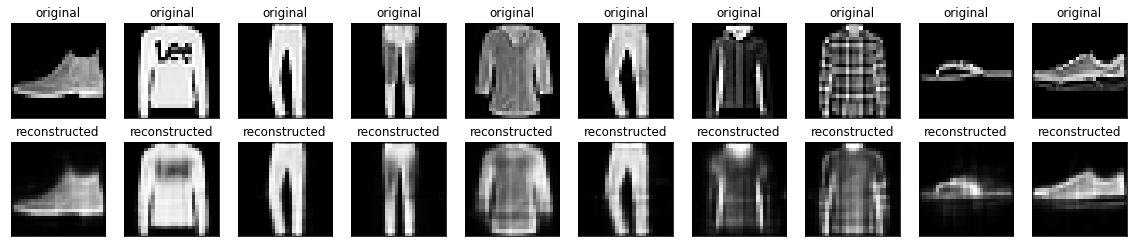

In [16]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plot(decoded_imgs=decoded_imgs)

## Denoising Autoencoders

An autoencoder can also be trained to remove noise from images.

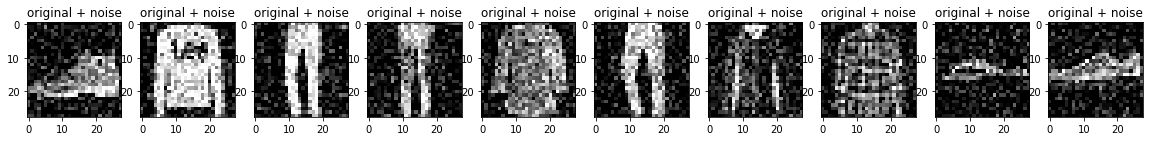

In [17]:
# add random noise to images and plot it

noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

In [21]:
# we can re-use the basic autoencoder changing training dataset with noisy images
autonecoder = Autoencoder(latent_dim)
build_fit(x_train=x_train, x_train_noisy=x_train_noisy,
          x_test=x_test, x_test_noisy=x_test_noisy, autoencoder=autoencoder, denoising=True)

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0145 - val_loss: 0.0146
Epoch 2/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0144 - val_loss: 0.0146
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0143 - val_loss: 0.0144
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0143 - val_loss: 0.0144
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0142 - val_loss: 0.0145
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0142 - val_loss: 0.0143
Epoch 7/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0142 - val_loss: 0.0142
Epoch 8/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0141 - val_loss: 0.0144
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0141 - val_loss: 0.0144
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.014

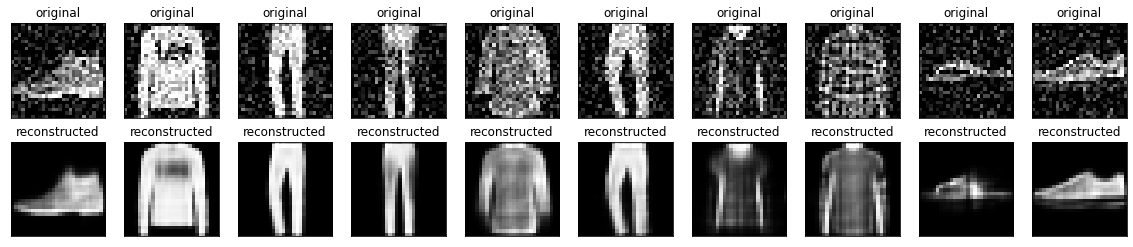

In [23]:
#plot
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plot(original=x_test_noisy, decoded_imgs=decoded_imgs)

In [24]:
# or we can use a convolutional model
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [26]:
autonecoder = Denoise()
build_fit(x_train=x_train, x_train_noisy=x_train_noisy,
          x_test=x_test, x_test_noisy=x_test_noisy, autoencoder=autoencoder, denoising=True)

Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0141 - val_loss: 0.0144
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0140 - val_loss: 0.0143
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0140 - val_loss: 0.0140
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0140 - val_loss: 0.0144
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0140 - val_loss: 0.0142
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0140 - val_loss: 0.0142
Epoch 7/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0140 - val_loss: 0.0141
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0139 - val_loss: 0.0142
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0139 - val_loss: 0.0143
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.013

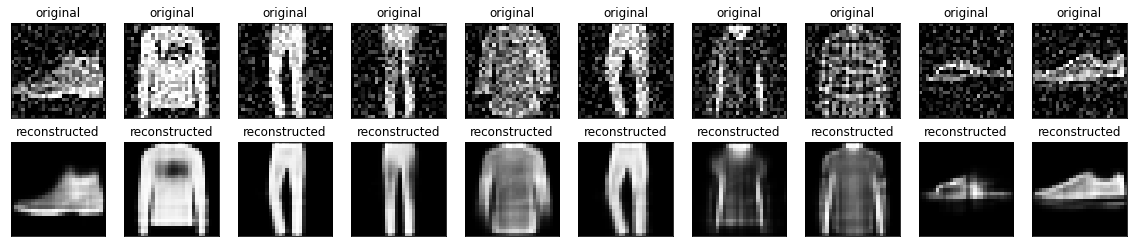

In [27]:
#plot
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plot(original=x_test_noisy, decoded_imgs=decoded_imgs)

## Contractive Autoencoders

In [34]:
#to do, define custom loss and use basic autoencoder
lambda_reg = 0.00001
def ContractiveLoss(y_true, y_pred):
  mse = losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)
  mean_squared_error = mse(y_true, y_pred)
  forbenius = tf.sqrt(tf.reduce_sum(tf.square(y_pred)))
  return mean_squared_error + (lambda_reg*forbenius)  

In [35]:
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=ContractiveLoss)
autoencoder.fit(x_train, x_train,
                  epochs=10,
                  shuffle=True,
                  validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 20.8434 - val_loss: 11.5993
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 10.2298 - val_loss: 9.4230
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 8.9437 - val_loss: 8.6367
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 8.4556 - val_loss: 8.3417
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 8.2081 - val_loss: 8.2242
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 8.0751 - val_loss: 8.0734
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 7.9852 - val_loss: 8.0451
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 7.9187 - val_loss: 7.9961
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 7.8725 - val_loss: 7.8977
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 7.

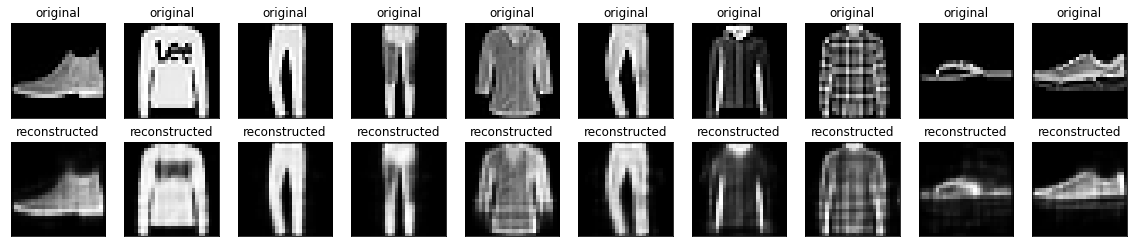

In [36]:
#plot
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plot(original=x_test, decoded_imgs=decoded_imgs)